- data from CARE paper: https://www.nature.com/articles/s41592-018-0216-7
- figure 2

In [45]:
%matplotlib inline
import matplotlib.pylab as plt
import os, sys, glob

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
import cellshapy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- read data

In [47]:
#fn = '../datasets/flywing_gt_instance_relabeled.tif'
fn = '../datasets/3_tracked/C4-flywing_gt_instance_relabeled_curated_labeled_tracked.tif'
from skimage import io
import numpy as np
im = io.imread(fn)

- get persistent IDs

In [48]:
sets = [set(np.unique(i)) for i in im]
ids = list(set.intersection(*sets))
# remove zero
ids = np.array([id for id in ids if id != 0])
#ids_selection = ids[::20]
ids_selection = ids
ids_selection

array([ 37,  38,  40,  41,  43,  44,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  60,  61,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  74,  75,  76,  77,  78,  79,  81,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,  98,
        99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127,
       128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 177, 178, 180, 181, 182, 183, 184, 185,
       186, 187, 189, 190, 191, 193, 194, 195, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 240, 241, 242, 24

- load in cellshapy

In [49]:
def crop(im):
    '''Crop zeros from array: https://stackoverflow.com/a/39466129'''
    # argwhere will give you the coordinates of every non-zero point
    coords = np.argwhere(im)
    # take the smallest points and use them as the top left of your crop
    # take the largest points and use them as the bottom right of your crop
    top_left, bottom_right = coords.min(axis=0), coords.max(axis=0)
    out = im[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
             top_left[1]:bottom_right[1]+1]  # inclusive
    return out
    

In [50]:
# create list to binary images
ims = [crop(im==id) for id in ids_selection]
# annotations
annotations = [{'cellid':id} for id in ids_selection]

In [51]:
# import
vc = cellshapy.VideoCollection.from_arrays(ims, annotations=annotations, normalize_area=None)

Creating VideoCollection from list of 576 arrays. video files or directories


In [52]:
_ = vc.align_contours()

Iteration 2, error: 0.000032, time: 109.60 sec
17280 contours aligned in 164.46 sec


- shape analysis

In [61]:
vc.embed_shapes(source='all', method='pca', n_components=2)
_ = vc.shape_space('contours', 'pca', colorcode='video', shape_size=1, components=[1,2],
                   show_shapes=True, show_trajectories=False,
                   alpha_face=.1, alpha_edge=.8, projection='umap')

`pca` embedding for `descriptors`reset `solidity` to mean-subtracted, not standardized
reset `waviness` to mean-subtracted, not standardized
reset `circularity` to mean-subtracted, not standardized
reset `eccentricity` to mean-subtracted, not standardized
 done (0.26 s).
`pca` embedding for `contours` done (0.23 s).


/Users/wdeback/Work/cellshapy/cellshapy/plotting/shapespace.py:51: UserWarning: No need to perform umap projection. Data already 2D.


(                            pearsonr  rotation (degree)  rotation (rad)
 equivalent diameter         0.588496          -1.599408       -0.027915
 perimeter hull              0.585001           2.458875        0.042915
 area                        0.583978          -1.824649       -0.031846
 area hull                   0.583588          -0.817615       -0.014270
 perimeter                   0.581814           2.776090        0.048452
 perimeter bbox              0.577148           0.451467        0.007880
 area bbox                   0.571924          -1.489978       -0.026005
 perimeter to area ratio     0.562458         175.153432        3.057004
 max caliper diameter        0.558126          12.300038        0.214676
 minor axis length           0.557936         -14.763392       -0.257670
 inscribing circle diameter  0.556938         -11.937910       -0.208356
 major axis length           0.550777          16.492526        0.287849
 min caliper diameter        0.542411         -12.5

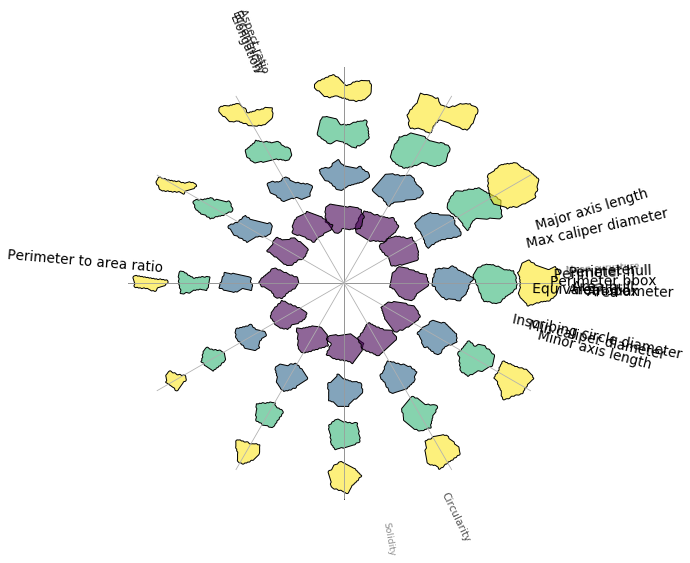

In [62]:
vc.shape_space_polar('contours', 'pca', num_bins=12, shape_size=30.0, label_threshold=0.1)

- morph analysis

`parafac` embedding for `stxy` done (5.82 s).


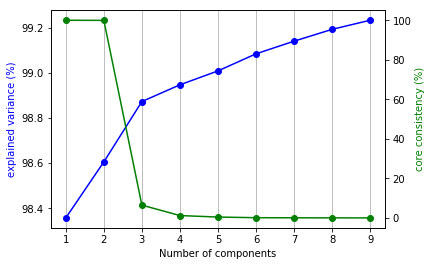

In [64]:
format = 'stxy'
method = 'parafac'
vc.embed_morphs(format, method, n_components=2, plot=False)

if method == 'parafac':
    df, _ = vc.parafac_diagnostics('stxy', max_components=10)

In [67]:
from cellshapy.analysis.embedding import tensor_reconstruction_errors
rec_err, rec_err_vids = tensor_reconstruction_errors(vc, 'stxy', 'parafac', 
                             max_components=10, stepsize=1, 
                             video_indices='all')
rec_err

`parafac` embedding for `stxy` done (0.43 s).


{1: 1.3153216022825336,
 2: 1.1168293166837642,
 3: 0.9029130734084554,
 4: 0.8435589777704261,
 5: 0.7942621031168812,
 6: 0.733757766824674,
 7: 0.688900915059681,
 8: 0.646991201745613,
 9: 0.6147433145316129}

In [74]:
from cellshapy.analysis.embedding import choose_elbow
choose_elbow(rec_err, window_size=5, order=3, plot=True)
import numpy as np
print(np.mean(np.array([choose_elbow(rec_err_vids[i], window_size=2, order=3, plot=False) 
                        for i in range(len(vc))])))


4.432291666666667


`parafac` embedding for `stxy` done (6.45 s).
components = None


/Users/wdeback/Work/cellshapy/cellshapy/plotting/morphspace.py:90: UserWarning: Projecting from 3 components to 2D using umap.


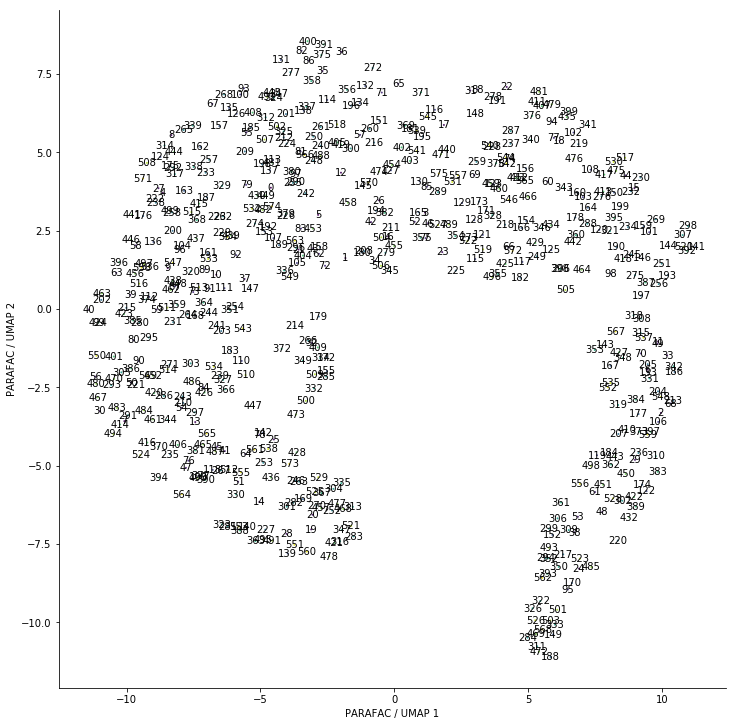

In [75]:
vc.embed_morphs(format, method, n_components=3, plot=False, save_embedding=True)
fig = vc.morph_space(format, method, animate=False, 
                         shape_size=1., alpha_face=0.8, projection='umap')

In [77]:
fig = vc.morph_space(format, method, animate=False, frames=[19,29],
                         shape_size=1., alpha_face=0.8, projection='umap')

components = None


/Users/wdeback/Work/cellshapy/cellshapy/plotting/morphspace.py:90: UserWarning: Projecting from 3 components to 2D using umap.


- cluster analysis

In [103]:
df = vc.cluster_morphs(format, method=method, cl_method='hdbscan', n_clusters=3, plot=True)
df.head()

/Users/wdeback/Work/cellshapy/cellshapy/analysis/cluster.py:36: UserWarning: 'n_clusters' is interpreted as 'min_cluster_size' in HDBSCAN.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [102]:
sorted(df['cluster'].unique())
df.hist('cluster')

KeyError: 'cluster'

## plot cluster labels back in image

In [99]:
def replace_value_in_image(cellids:np.array, values:np.array, filename:str):

    from skimage.external import tifffile

    # WARNING: SLOW
    # create image with only the selected cell IDs
    im_clean = np.zeros(im.shape, dtype=np.int)
    for id in cellids:
        im_clean += id*(im==id)
    
    # dict to translate cell IDs into cluster label
    id_to_cluster = dict(zip(ids_selection, values))
    
    # fast 'replacing' values in numpy array: https://stackoverflow.com/a/3404089
    from numpy import copy
    im_cluster = np.zeros(im_clean.shape, dtype=np.float32)
    for k, v in id_to_cluster.items(): 
        im_cluster[im_clean==k] = v
                                
    tifffile.imsave(filename, data=im_cluster, compress=6)

In [101]:
cellids = ids_selection
values = (df['cluster']+2)*(255//(df['cluster'].max()+2))
outfile = '../datasets/output/flywing_cellshapy_output.tif'
replace_value_in_image(cellids, values, outfile)

KeyError: 'cluster'

In [89]:
#print*np.unique(im_clean))
#print(np.unique(im_cluster))
#len(np.unique(im_cluster))

## select only those with certain label

In [93]:
len([v for v in vc if v.annotations['cluster'] == 2])

544

In [95]:
selection = cellshapy.VideoCollection()
selection.videos = [v for v in vc if v.annotations['cluster'] == 2]

- morph analysis on selected videos

`parafac` embedding for `stxy` done (5.36 s).


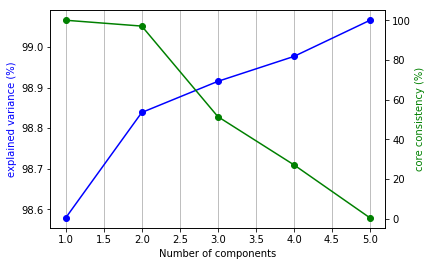

In [113]:
selection.embed_morphs('stxy', 'parafac', n_components=3, plot=False)
df, _ = selection.parafac_diagnostics('stxy', max_components=6)

`tucker` embedding for `stxy`

/Users/wdeback/anaconda/envs/cellshapy/lib/python3.6/site-packages/tensorly/decomposition/_tucker.py:60: Warning: Given only one int for 'rank' intead of a list of 3 modes. Using this rank for all modes.


 done (0.43 s).
components = None


/Users/wdeback/Work/cellshapy/cellshapy/plotting/morphspace.py:90: UserWarning: Projecting from 8 components to 2D using pca.


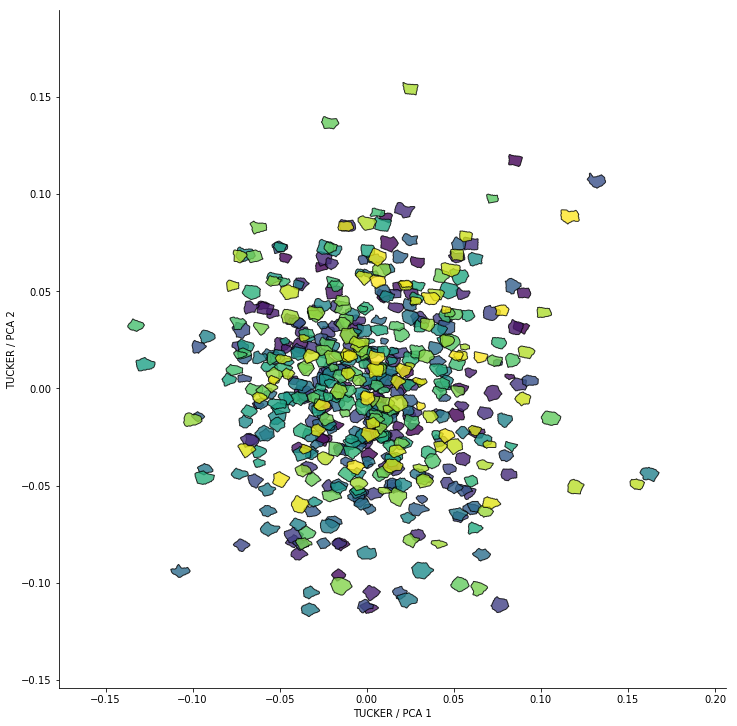

In [178]:
format = 'stxy'
selection.embed_morphs(format, 'tucker', n_components=8, plot=False, save_embedding=True)
fig = selection.morph_space(format, 'tucker', animate=False, frames=[20],
                         shape_size=1., alpha_face=0.8, projection='pca')

- cluster analysis

In [173]:
df_cl_sel = selection.cluster_morphs('stxy', method='tucker', cl_method='hdbscan', n_clusters=5, plot=True)
df_cl_sel.head()

/Users/wdeback/Work/cellshapy/cellshapy/analysis/cluster.py:36: UserWarning: 'n_clusters' is interpreted as 'min_cluster_size' in HDBSCAN.


cluster  video
0        0      0
1        1      1
2        0      2
3        0      3
4        0      4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x984adeb70>]],
      dtype=object)

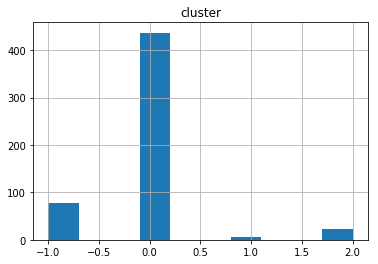

In [174]:
sorted(df_cl_sel['cluster'].unique())
df_cl_sel.hist('cluster')

In [177]:
fig = selection.morph_space(format, 'tucker', animate=False, frames=[29],
                         shape_size=1., alpha_face=0.8, projection='pca', colorcode='cluster')

#fig

components = None


/Users/wdeback/Work/cellshapy/cellshapy/plotting/morphspace.py:90: UserWarning: Projecting from 2 components to 2D using pca.


In [163]:
cellids = [vid.annotations['cellid'] for vid in selection]
values = (df_cl_sel['cluster']+2)*(255//(df_cl_sel['cluster'].max()+2)) # draw cluster values
#values = [v.embedding[('stxy', 'parafac')][0] for v in selection] # draw raw values
outfile = '../datasets/output/flywing_cellshapy_output_selection.tif'
replace_value_in_image(cellids, values, outfile)